# Building a neural network to predict Churn

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Importing datasets

In [2]:
X_train, y_train, X_test, y_test = pickle.load(open("desafio_1_data.pkl", 'rb'))

# Datasets ready to go into the neural networks!
# Data pre-processing is in the other notebook

In [3]:
X_train.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,DSL,NoInternetService,OneyearContract,TwoyearContract,BanktransferPay,CreditcardPay,MailedcheckPay,tenure_n,MonthlyCharges_n,TotalCharges_n,monthly_sobre_total_n,Cant_productos_n,Cant_productos_internet_n,MonthlyCharges_d2_0,MonthlyCharges_d2_1,MonthlyCharges_d2_2,TotalCharges_d2_0,TotalCharges_d2_1,TotalCharges_d2_2,TotalCharges_d2_3,TotalCharges_d2_4,TotalCharges_d2_5,TotalCharges_d2_6,TotalCharges_d2_7,tenure_d2_0,tenure_d2_1,tenure_d2_2,tenure_d2_3,tenure_d2_4,tenure_d2_5,tenure_d2_6,tenure_d2_7
count,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4.711000e+03,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000,4711.000000
mean,0.487370,0.161961,0.481851,0.298026,0.901083,0.416472,0.288262,0.348334,0.344725,0.288686,0.386118,0.391849,0.593292,0.344301,0.218425,0.210359,0.242411,0.209934,0.220972,0.226491,4.562496e-17,1.659089e-16,-3.469005e-17,-5.278921e-18,-7.239663e-17,1.176445e-16,0.200382,0.399703,0.399915,0.100616,0.099554,0.099979,0.099979,0.199958,0.099979,0.199958,0.099979,0.116960,0.093611,0.104224,0.093611,0.192953,0.205901,0.097856,0.094884
std,0.499894,0.368454,0.499724,0.457439,0.298583,0.493026,0.453002,0.476493,0.475329,0.453200,0.486910,0.488215,0.491272,0.475190,0.413221,0.407607,0.428587,0.407305,0.414946,0.418605,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,0.400329,0.489889,0.489933,0.300851,0.299437,0.300004,0.300004,0.400011,0.300004,0.400011,0.300004,0.321407,0.291317,0.305584,0.291317,0.394658,0.404401,0.297151,0.293086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.274391e+00,-1.541340e+00,-9.964857e-01,-5.144577e-01,-1.466687e+00,-1.112415e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.494104e-01,-9.758785e-01,-8.286698e-01,-4.960046e-01,-1.466687e+00,-1.112415e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.369580e-01,1.874268e-01,-3.909644e-01,-4.345622e-01,6.818088e-01,-2.605782e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.598528e-01,8.367522e-01,6.533569e-01,-1.445206e-01,6.818088e-01,5.171209e-01,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000

# Defining functions to build models and to create visualizations

In [4]:
def build_model(name='Basic model', layers=(64,), 
                optimizer=keras.optimizers.RMSprop(), 
                metric = keras.metrics.binary_accuracy,
                kernel_regularizer=None,
                dropout=None,
                batch_normalization=None):
    
    #Initialization. Name based on input
    model  = Sequential(name=name)
    
    #Hidden layers: based on input
    for i,l in enumerate(layers):
        if i == 0:
            model.add(Dense(l, activation='relu', input_shape=(X_train.shape[1],)))
            continue
        if batch_normalization is not None:
            model.add(Dense(l))
            model.add(BatchNormalization())
            model.add(Activation(batch_normalization))
            continue
        model.add(Dense(l, activation='relu',kernel_regularizer=kernel_regularizer))
        if dropout is not None:
            model.add(Dropout(dropout))
    
    #Final layer: Binary classifier --> 1 neuron, sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    
    #Compilation: Optimizer based on input; Binary classifier --> binary crossentropy loss function
    model.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy, metrics=[metric])
    
    return model

def plot_history(history, metrics=['loss','binary_accuracy'], plot_val=True):
    if not isinstance(history, list):
        history = [history]
    if not isinstance(metrics, list):
        metrics = [metrics]
    
    fig, ax = plt.subplots(1,len(metrics),figsize=(14,6))
    fig.suptitle(history[0].model.name)
    for h in history:
        vars_to_plot = []
        for m in metrics:
            metric = dict(name=m, train=h.history[m])
            if plot_val:
                metric['val'] = h.history[f'val_{m}']
            vars_to_plot.append(metric)
        epochs = range(1, len(vars_to_plot[0]['train']) + 1)
        
        for idx, var in enumerate(vars_to_plot):
        
            ax[idx].set_title(var['name'])
            #ax[idx].set_xticks(ticks=epochs)
            ax[idx].set_ylabel(var['name'])
        
            ax[idx].plot(epochs, var['train'])
            if plot_val:
                ax[idx].plot(epochs, var['val'])
            ax[idx].legend([l +' ' + var['name'] for l in ['train', 'val']])
            
def compare_histories(histories, metrics=['loss','binary_accuracy','val_loss','val_binary_accuracy']):
    if not isinstance(metrics, list):
        metrics = [metrics]
        
    epochs = range(1, len(histories[0].history[metrics[0]]) + 1) 
    fig, ax = plt.subplots(1,len(metrics),figsize=(14,6))
    fig.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    fig.suptitle('Comparisons')
    for idx, m in enumerate(metrics):
        ax[idx].set_title(m)
        #ax[idx].set_xticks(ticks=epochs)
        #ax[idx].set_ylabel(m)
        for history in histories:
            ax[idx].plot(epochs, history.history[m])
        if idx == 0:
            ax[idx].legend([history.model.name for history in histories])

# Splitting train and validation datasets

In [5]:
from sklearn.model_selection import train_test_split

partial_train_data, val_data, partial_train_targets, val_targets = train_test_split(X_train, y_train, 
                                                                                    test_size=0.33, random_state=42)

# Testing different architectures

## Using GridSearchCV

In [66]:
import itertools
# Definimos la "grilla" de parámetros que vamos a explorar
layers_to_test = [1,2,3,4]
neurons_per_layer_to_test = [2, 4, 8, 16, 32, 64, 128, 256]
architecture_combinations = []
for l in layers_to_test:
    for n in neurons_per_layer_to_test:
        combination = [n for x in range(l)]
        architecture_combinations.append(tuple(combination))

In [92]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

wrapper = KerasClassifier(build_model, batch_size=16, epochs=20, verbose=0)

params = {'layers': architecture_combinations}
grid = GridSearchCV(wrapper, params, cv=5,  scoring = 'f1')
grid.fit(partial_train_data, partial_train_targets,
         validation_data=(val_data, val_targets),
         batch_size=16, epochs=20, verbose=0)
print(grid.best_score_.round(2))
print('Best model architecture:', grid.best_estimator_.get_params()['layers'])

0.6
Best model architecture: (8, 8, 8)


## Manually testing some architectures in detail

In [93]:
model_templates = [dict(name='3x4', 
                       layers=(4,4,4), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy),
                  dict(name='3x8', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy),
                  dict(name='3x32', 
                       layers=(32,32,32), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy)]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [94]:
histories_base = []
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_base.append(history)

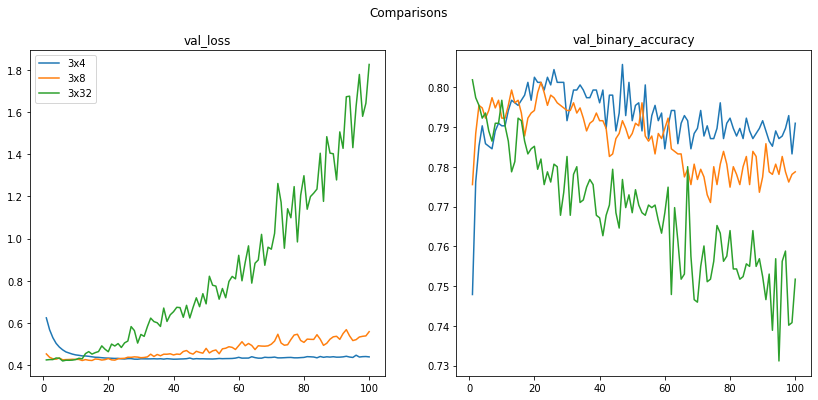

In [96]:
compare_histories(histories_base, metrics=['val_loss','val_binary_accuracy'])

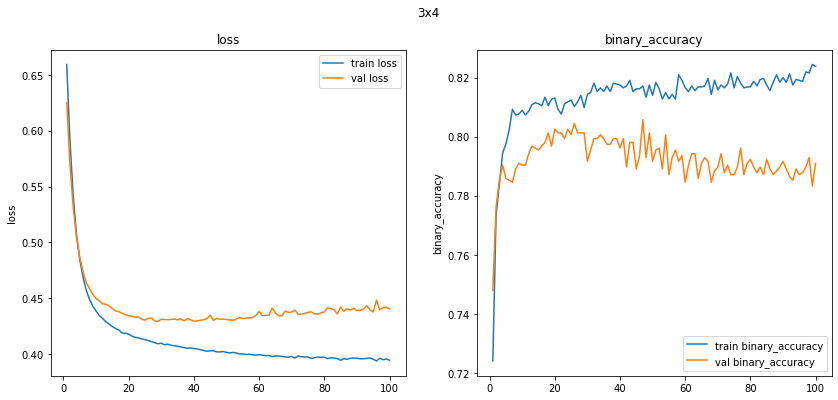

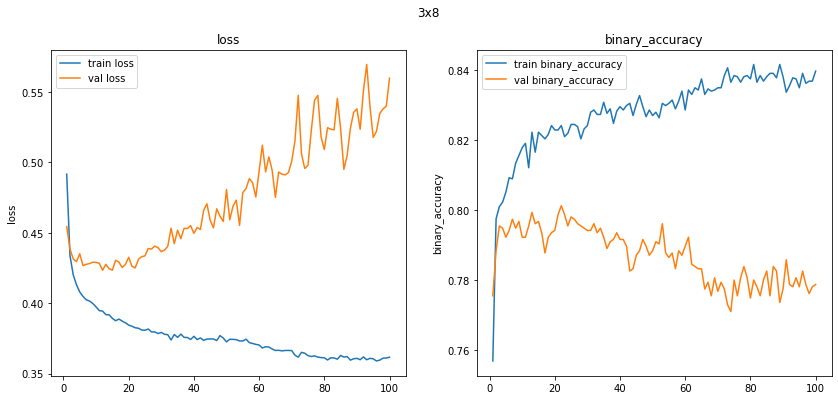

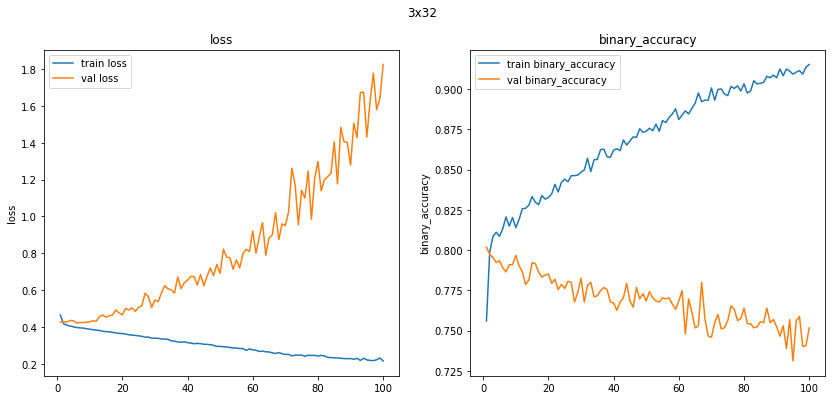

In [97]:
for history in histories_base:
    plot_history(history)

# All of them are overfitting!

# Base model: 3x8

In [100]:
selected_model_base = histories_base[1]
selected_model_base.model.summary()

Model: "3x8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2142 (Dense)           (None, 8)                 368       
_________________________________________________________________
dense_2143 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2144 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2145 (Dense)           (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


## Regularization

In [107]:
model_templates = [dict(name='3x8 L1', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy,
                       kernel_regularizer=keras.regularizers.l1(0.01)),
                  dict(name='3x8 L2', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy,
                       kernel_regularizer=keras.regularizers.l2(0.01))]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [108]:
histories_regularization = [selected_model_base]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_regularization.append(history)

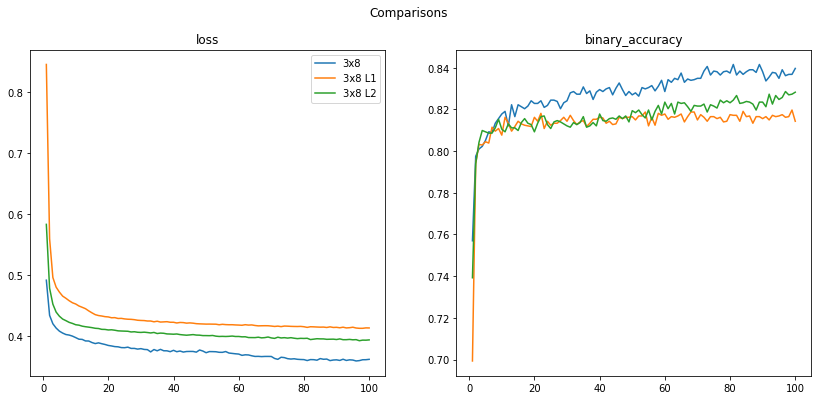

In [111]:
compare_histories(histories_regularization, metrics=['loss','binary_accuracy'])

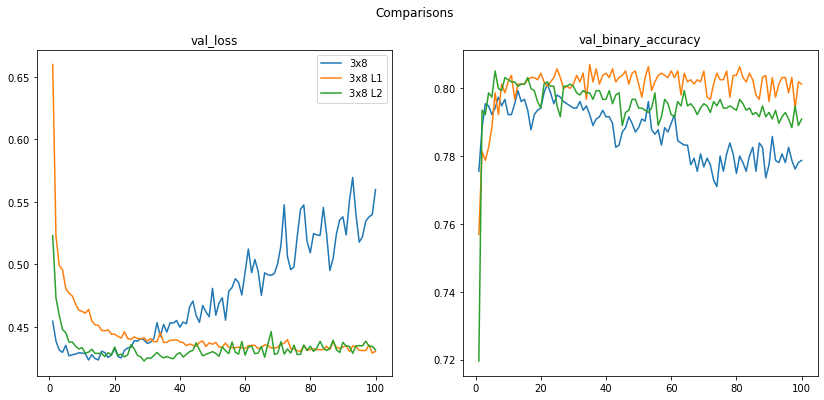

In [109]:
compare_histories(histories_regularization, metrics=['val_loss','val_binary_accuracy'])

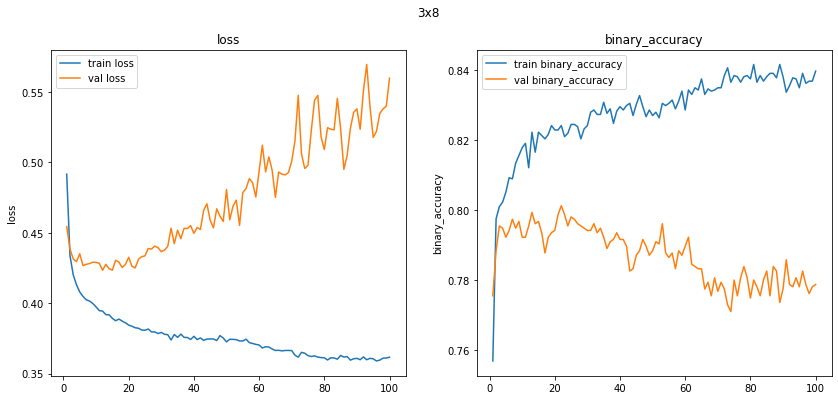

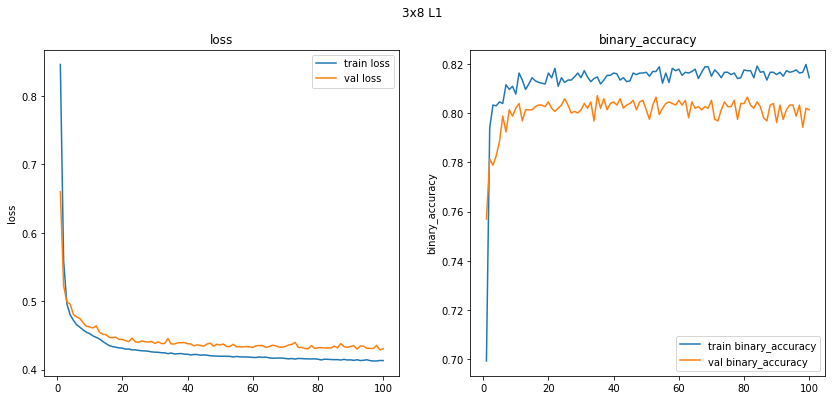

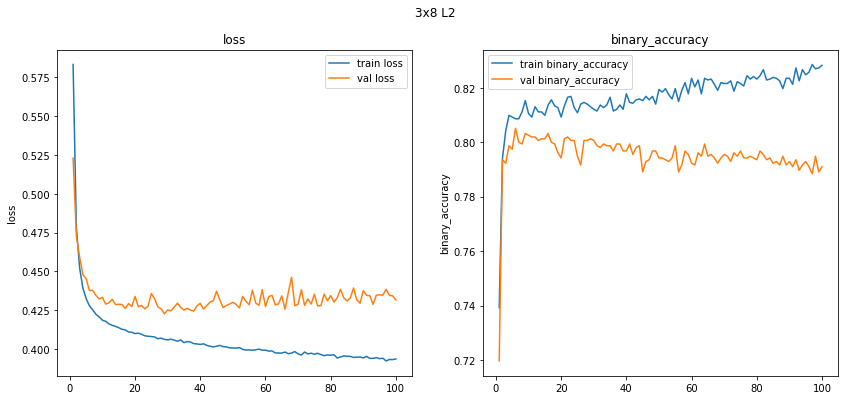

In [110]:
for history in histories_regularization:
    plot_history(history)

# Regularization L1 improves the overfitting

In [115]:
selected_regularized_model = histories_regularization[1]
selected_regularized_model.model.summary()

Model: "3x8 L1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2166 (Dense)           (None, 8)                 368       
_________________________________________________________________
dense_2167 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2168 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2169 (Dense)           (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


# Dropout

In [118]:
wrapper = KerasClassifier(build_model, layers=(8,8,8), 
                          batch_size=16, epochs=20, verbose=0)
dropout_rates_to_test = [0, 0.1, 0.5, 1, 2, 5]
params = {'dropout': dropout_rates_to_test}
grid = GridSearchCV(wrapper, params, cv=5,  scoring = 'f1')
grid.fit(partial_train_data, partial_train_targets,
         validation_data=(val_data, val_targets),
         batch_size=16, epochs=20, verbose=0)
print(grid.best_score_.round(2))
print('Best model dropout rate:', grid.best_estimator_.get_params()['dropout'])

0.59
Best model dropout rate: 0


In [121]:
def build_regularized_model(name='Regularized model', layers=(8,8,8), optimizer=keras.optimizers.RMSprop(), 
                            metric = keras.metrics.binary_accuracy, kernel_regularizer=keras.regularizers.l1(0.01),
                            dropout=None, batch_normalization=None):
    return build_model(name=name, layers=layers, optimizer=optimizer, metric = metric,
                        kernel_regularizer=kernel_regularizer, dropout=dropout,
                        batch_normalization=batch_normalization)

wrapper = KerasClassifier(build_regularized_model, batch_size=16, epochs=20, verbose=0)
dropout_rates_to_test = [0, 0.1, 0.5, 1, 2, 5]
params = {'dropout': dropout_rates_to_test}
grid = GridSearchCV(wrapper, params, cv=5,  scoring = 'f1')
grid.fit(partial_train_data, partial_train_targets,
         validation_data=(val_data, val_targets),
         batch_size=16, epochs=20, verbose=0)
print(grid.best_score_.round(2))
print('Best model dropout rate:', grid.best_estimator_.get_params()['dropout'])

0.59
Best model dropout rate: 1


# GridsearchCV selected dropout_rate = 1
# Comparing it with model without dropout

In [125]:
model_templates = [dict(name='3x8 dropout 1', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       metric=keras.metrics.binary_accuracy,
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       dropout=0.5),]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [126]:
histories_dropout = [selected_regularized_model]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_dropout.append(history)

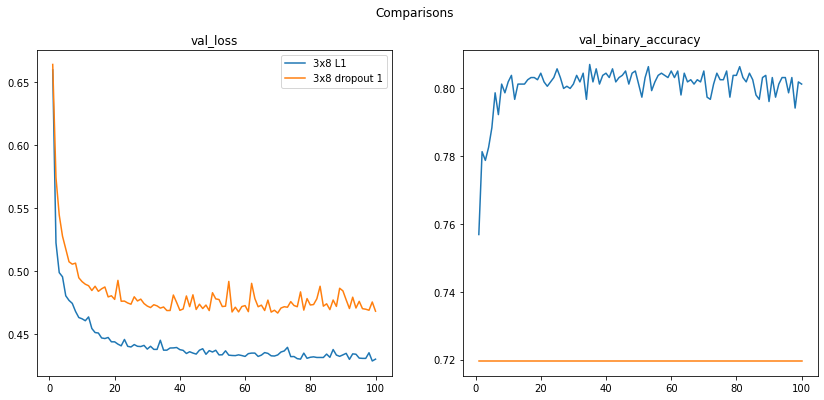

In [127]:
compare_histories(histories_dropout, metrics=['val_loss','val_binary_accuracy'])

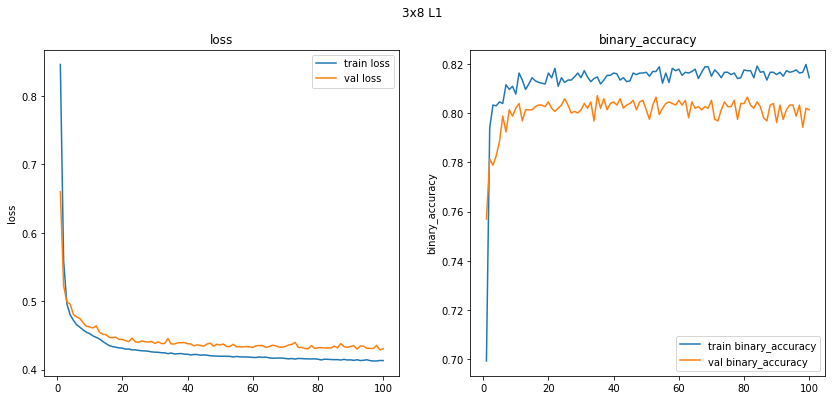

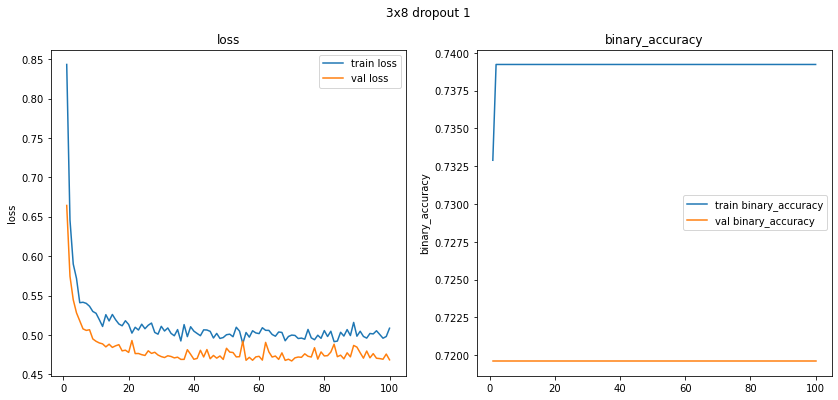

In [128]:
for history in histories_dropout:
    plot_history(history)

# We won't add Dropout to our model

# Optimizers

In [132]:
model_templates = [dict(name='3x8 SGD', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy),
                   dict(name='3x8 SGD + Momentum', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy),
                   dict(name='3x8 SGD + Momentum + Nesterov', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy),
                  dict(name='3x8 Adam', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.Adam(), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy)]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [138]:
histories_optimizers = [selected_regularized_model]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=16,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_optimizers.append(history)

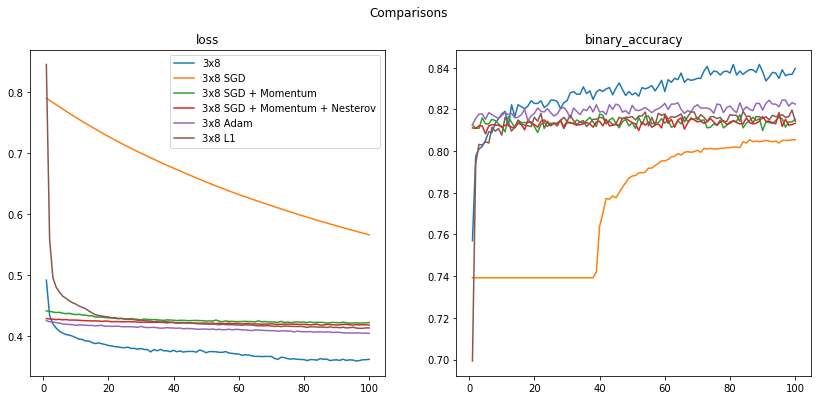

In [145]:
compare_histories(histories_optimizers, metrics=['loss','binary_accuracy'])

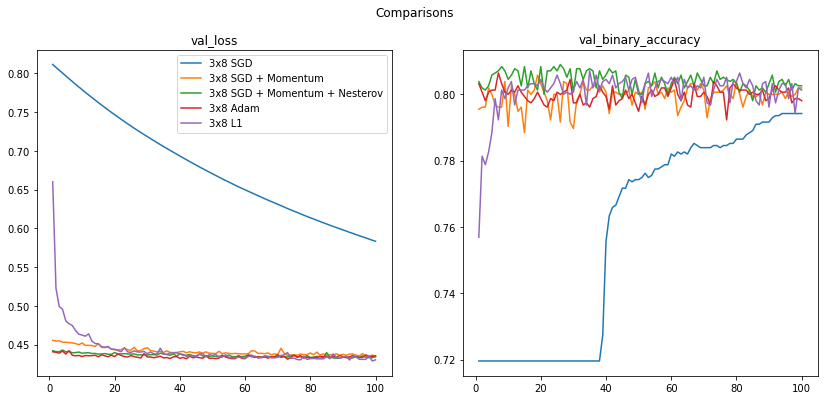

In [143]:
compare_histories(histories_optimizers, metrics=['val_loss','val_binary_accuracy'])

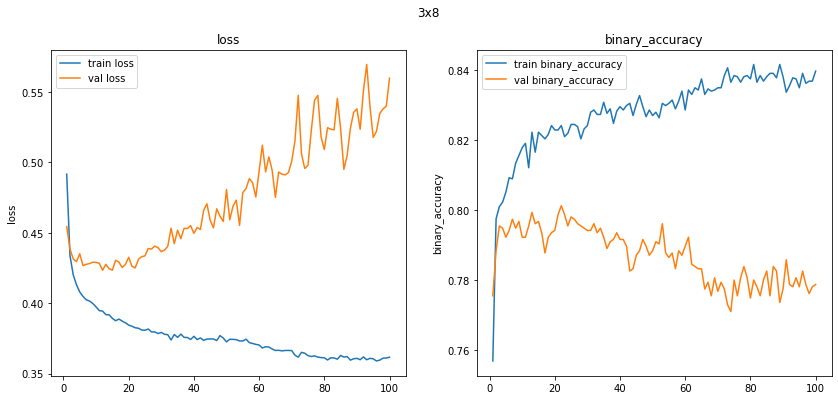

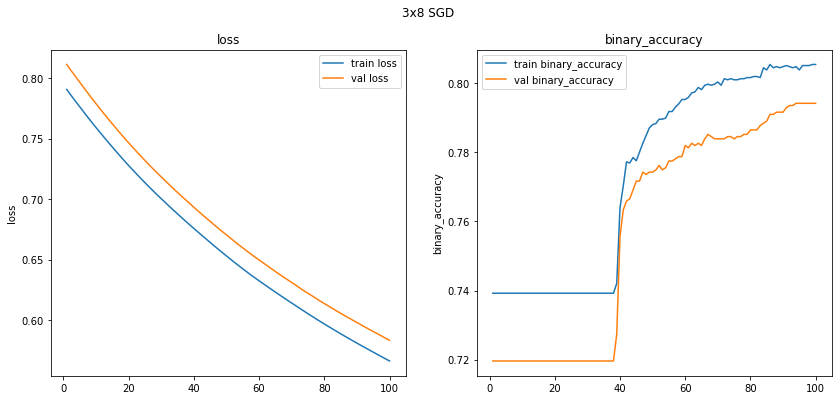

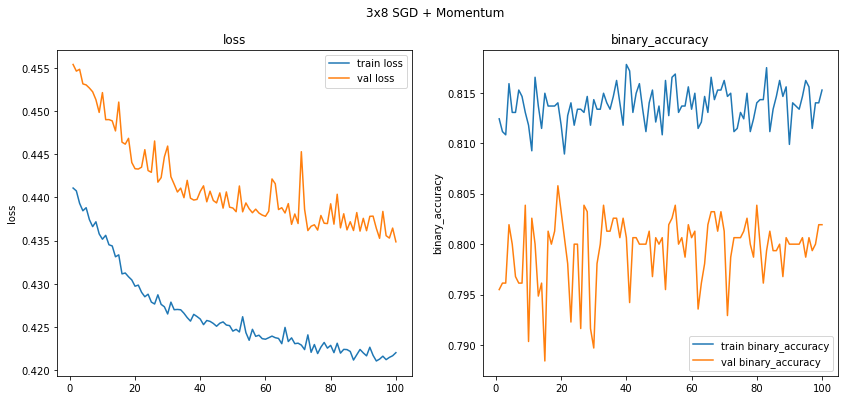

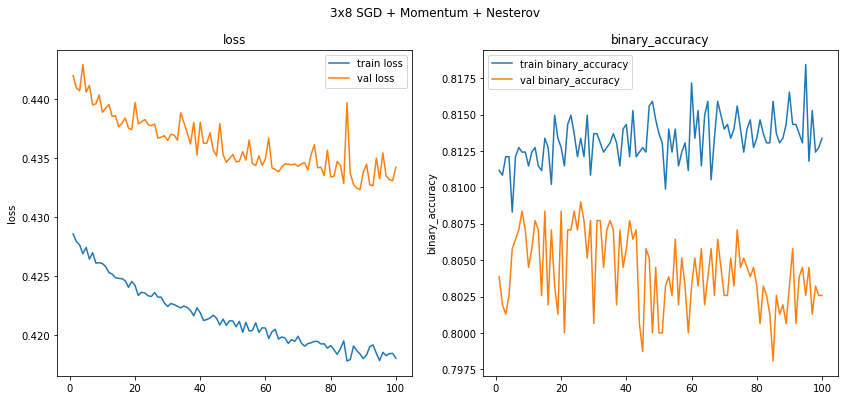

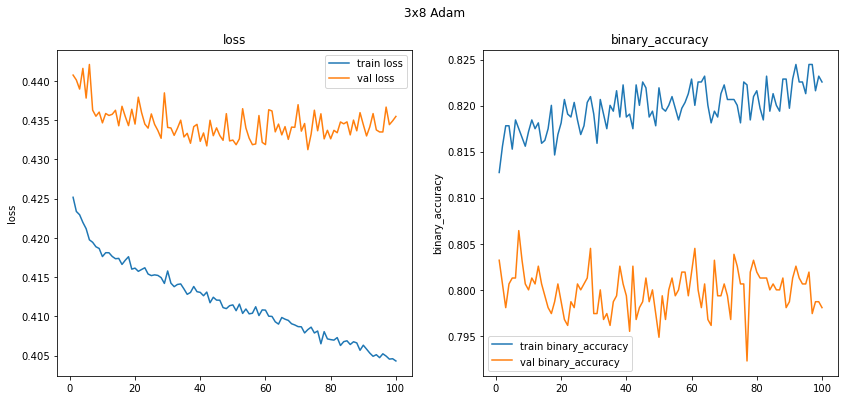

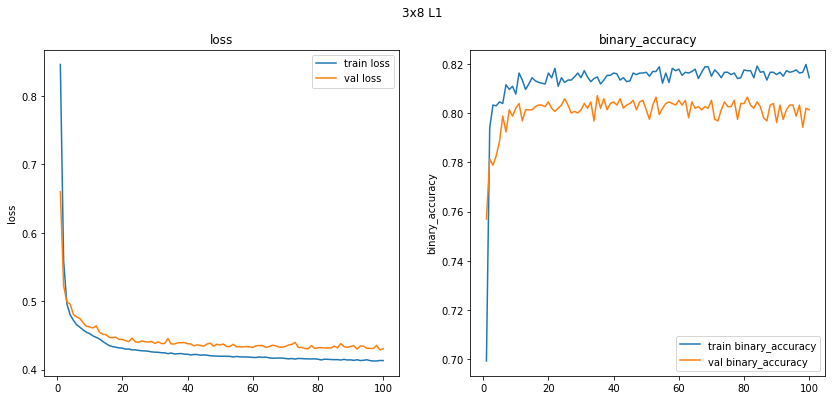

In [144]:
for history in histories_optimizers:
    plot_history(history)

In [156]:
for h in histories_optimizers:
    print(f"{round(max(h.history['val_binary_accuracy']),3)} max val_binary_accuracy - {h.model.name}")

0.801 max val_binary_accuracy - 3x8
0.794 max val_binary_accuracy - 3x8 SGD
0.806 max val_binary_accuracy - 3x8 SGD + Momentum
0.809 max val_binary_accuracy - 3x8 SGD + Momentum + Nesterov
0.806 max val_binary_accuracy - 3x8 Adam
0.807 max val_binary_accuracy - 3x8 L1


# Best seems to be SGD + Momentum + Nesterov and RMSProp

In [161]:
selected_optimized_model = histories_optimizers[3]
selected_optimized_model.model.summary()

Model: "3x8 SGD + Momentum + Nesterov"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2762 (Dense)           (None, 8)                 368       
_________________________________________________________________
dense_2763 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2764 (Dense)           (None, 8)                 72        
_________________________________________________________________
dense_2765 (Dense)           (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


# Batch normalization

In [8]:
from keras.layers import BatchNormalization, Activation

model_templates = [dict(name='3x8 L1 RMSprop norm relu', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu'),
                  dict(name='3x8 L1 RMSprop norm sigmoid', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.RMSprop(), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid'),
                  dict(name='3x8 L1 SGD + Momentum + Nesterov norm relu', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),  
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='relu'),
                  dict(name='3x8 L1 SGD + Momentum + Nesterov norm sigmoid', 
                       layers=(8,8,8), 
                       optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
                       kernel_regularizer=keras.regularizers.l1(0.01),
                       metric=keras.metrics.binary_accuracy,
                       batch_normalization='sigmoid')]

models = []
for template in model_templates:
    model = build_model(**template)
    models.append(model)

In [163]:
histories_normalization = [selected_regularized_model, selected_optimized_model]
for model in models:
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=8,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    histories_normalization.append(history)

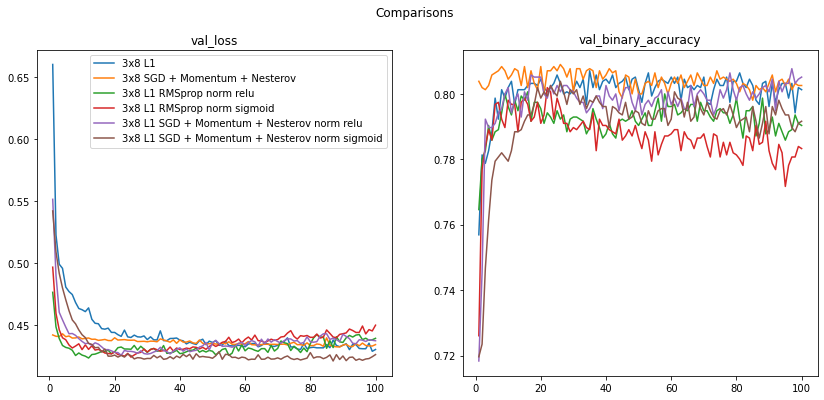

In [164]:
compare_histories(histories_normalization, metrics=['val_loss','val_binary_accuracy'])

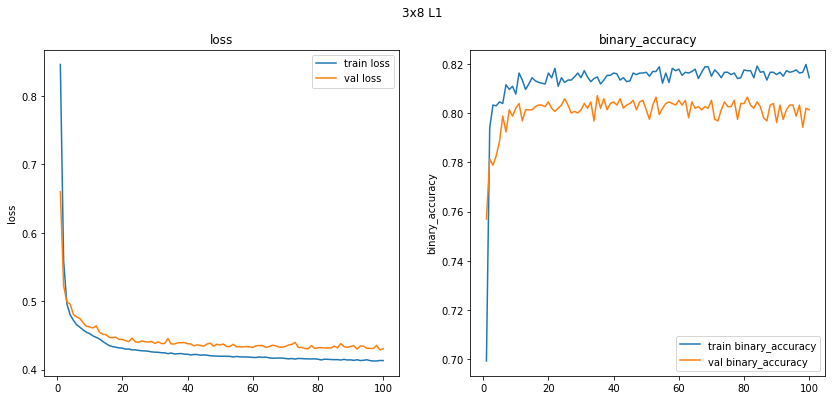

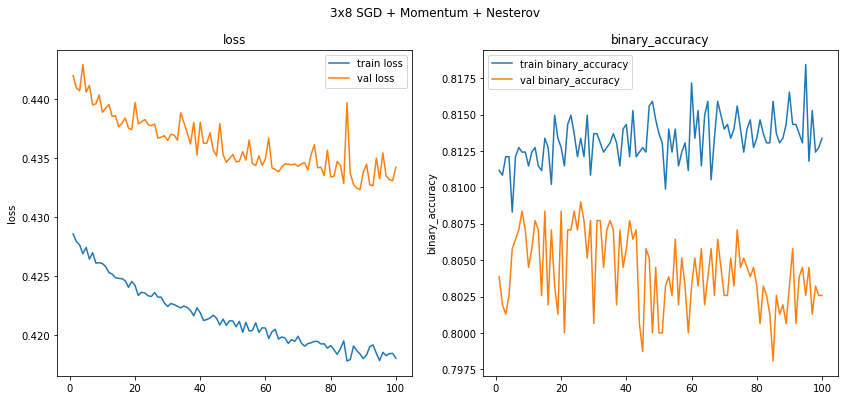

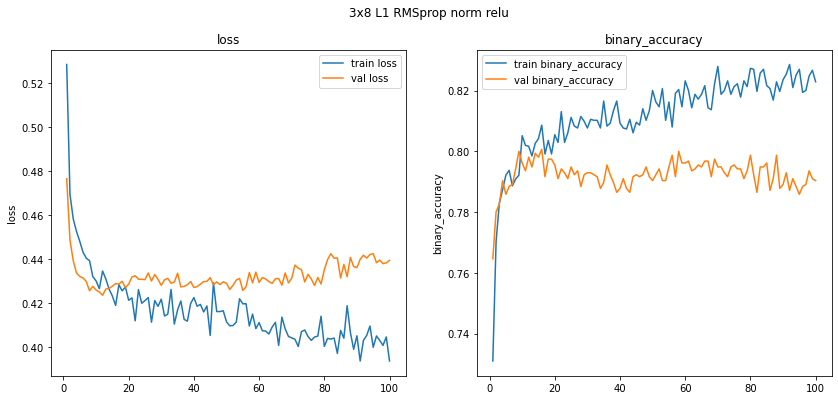

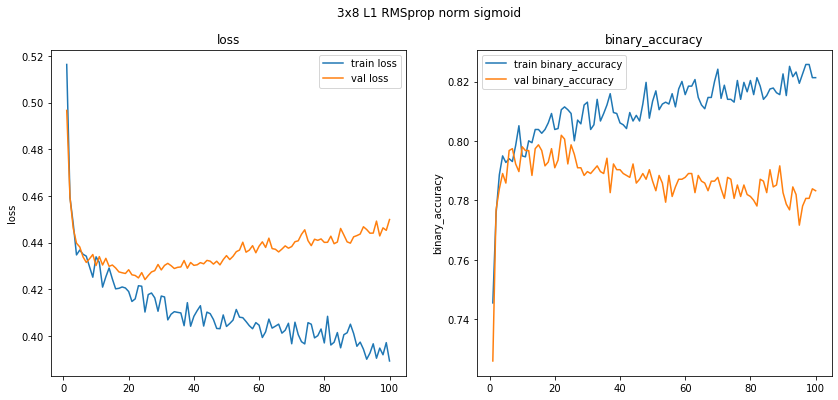

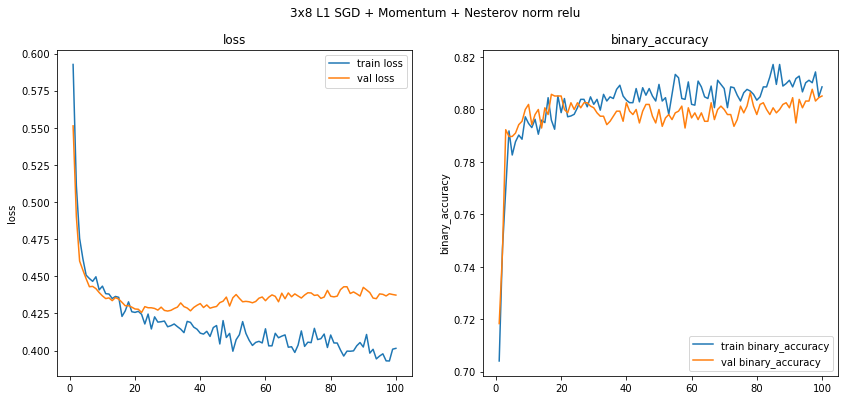

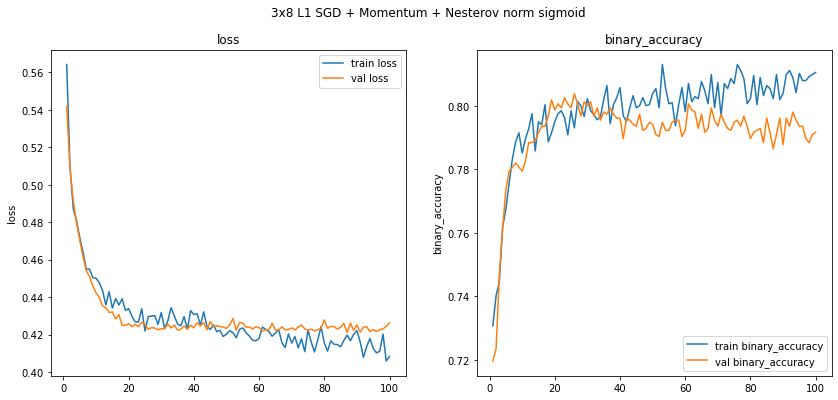

In [165]:
for history in histories_normalization:
    plot_history(history)

In [166]:
for h in histories_normalization:
    print(f"{round(max(h.history['val_binary_accuracy']),3)} max val_binary_accuracy - {h.model.name}")

0.807 max val_binary_accuracy - 3x8 L1
0.809 max val_binary_accuracy - 3x8 SGD + Momentum + Nesterov
0.801 max val_binary_accuracy - 3x8 L1 RMSprop norm relu
0.802 max val_binary_accuracy - 3x8 L1 RMSprop norm sigmoid
0.808 max val_binary_accuracy - 3x8 L1 SGD + Momentum + Nesterov norm relu
0.804 max val_binary_accuracy - 3x8 L1 SGD + Momentum + Nesterov norm sigmoid


In [171]:
for h in histories_normalization:
    print(f"{round(min(h.history['val_loss']),3)} min val_loss - {h.model.name}")

0.429 min val_loss - 3x8 L1
0.432 min val_loss - 3x8 SGD + Momentum + Nesterov
0.423 min val_loss - 3x8 L1 RMSprop norm relu
0.424 min val_loss - 3x8 L1 RMSprop norm sigmoid
0.426 min val_loss - 3x8 L1 SGD + Momentum + Nesterov norm relu
0.421 min val_loss - 3x8 L1 SGD + Momentum + Nesterov norm sigmoid


# Batch normalization with relu activation on SGD + Momentum + Nesterov seems to lower val_loss without compromising val_binary_accuracy much

# Early stopping and ReduceLROnPlateau

In [248]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

# Training best model

In [422]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1,
                                   save_best_only=True, save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
callbacks_list = [model_checkpoint, reduce_lr]
best_template = dict(name='3x8 L1 SGD + Momentum + Nesterov norm relu',
                     layers=(8,8,8), 
                     optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),  
                     kernel_regularizer=keras.regularizers.l1(0.01),
                     metric=keras.metrics.binary_accuracy,
                     batch_normalization='relu')
model = build_model(**best_template)

history = model.fit(partial_train_data, partial_train_targets,
                    epochs=20, batch_size=8,
                    validation_data=(val_data, val_targets),
                    callbacks=callbacks_list)

Train on 3156 samples, validate on 1555 samples
Epoch 1/20
3156/3156 [==============================] - 2s 673us/step - loss: 0.5674 - binary_accuracy: 0.6952 - val_loss: 0.4906 - val_binary_accuracy: 0.7434

Epoch 00001: val_loss improved from inf to 0.49058, saving model to weights.01-0.49.hdf5
Epoch 2/20
3156/3156 [==============================] - 1s 416us/step - loss: 0.4899 - binary_accuracy: 0.7630 - val_loss: 0.4705 - val_binary_accuracy: 0.7486

Epoch 00002: val_loss improved from 0.49058 to 0.47054, saving model to weights.02-0.47.hdf5
Epoch 3/20
3156/3156 [==============================] - 1s 450us/step - loss: 0.4605 - binary_accuracy: 0.7763 - val_loss: 0.4516 - val_binary_accuracy: 0.7730

Epoch 00003: val_loss improved from 0.47054 to 0.45156, saving model to weights.03-0.45.hdf5
Epoch 4/20
3156/3156 [==============================] - 1s 445us/step - loss: 0.4560 - binary_accuracy: 0.7776 - val_loss: 0.4429 - val_binary_accuracy: 0.7878

Epoch 00004: val_loss improved fr

In [423]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 39us/step


In [424]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.4097868664974216; Train acc: 0.7962216138839722
Test loss: 0.4228337617692943; Test acc: 0.8013787269592285


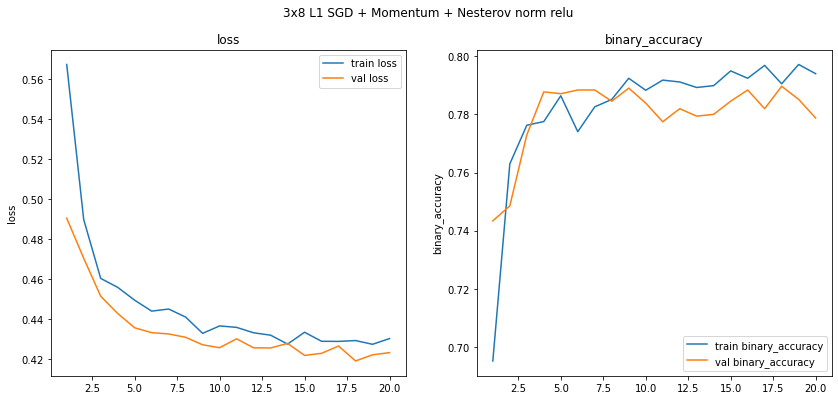

In [427]:
plot_history(history)

# Importing best weights generated by ModelCheckpoint

In [9]:
best_template = dict(name='3x8 L1 SGD + Momentum + Nesterov norm relu',
                     layers=(8,8,8), 
                     optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), 
                     kernel_regularizer=keras.regularizers.l1(0.01),
                     metric=keras.metrics.binary_accuracy,
                     batch_normalization='relu')
model = build_model(**best_template)


# Testing initial weights to see enhancements

In [10]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 34us/step


In [11]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.6449822348739609; Train acc: 0.7134366631507874
Test loss: 0.64592390261247; Test acc: 0.7130547165870667


# Loading ModelCheckpoint weights

In [12]:
model.load_weights('3x8 L1 SGD + Momentum + Nesterov norm relu weights.18-0.42.hdf5')

In [13]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

2321/2321 [==============================] - 0s 35us/step


In [14]:
print(f'Train loss: {train_loss}; Train acc: {train_acc}')
print(f'Test loss: {test_loss}; Test acc: {test_acc}')

Train loss: 0.40858402423128865; Train acc: 0.8036510348320007
Test loss: 0.4209497675768315; Test acc: 0.8026712536811829


In [15]:
model.summary()

Model: "3x8 L1 SGD + Momentum + Nesterov norm relu"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 8)                 368       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_9 (Batch (None, 8)                 32        
_________________________________________________________________
activation_9 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_10 (Batc (None, 8)                 32        
_________________________________________________________________
activation_10 (Activatio

# Thanks!